get building from png

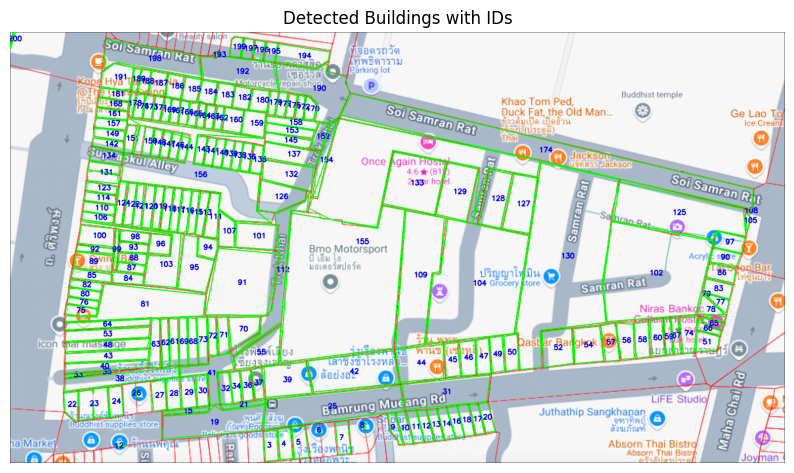

Exported buildings.json สำเร็จ!


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

# โหลดภาพ
img = cv2.imread('map_test2.png')
if img is None:
    raise ValueError("Image not found")

# วาดกรอบเทา
h, w = img.shape[:2]
cv2.rectangle(img, (0, 0), (w-1, h-1), (50, 50, 50), 1)

# แปลงไป HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# กำหนดสี
lower_red1 = np.array([0, 70, 50])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 70, 50])
upper_red2 = np.array([180, 255, 255])

# ทำ mask
red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
combined_mask = cv2.bitwise_or(red_mask1, red_mask2)

# Dilate
kernel = np.ones((3, 3), np.uint8)
combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_DILATE, kernel)

contours, hierarchy = cv2.findContours(combined_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

buildings = {}


building_id = 1

img_copy = img.copy()

if hierarchy is not None:
    hierarchy = hierarchy[0]
    for i, cnt in enumerate(contours):
        if hierarchy[i][2] == -1:
            epsilon = 0.01 * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)

            cv2.drawContours(img_copy, [approx], 0, (0, 255, 0), 2)

    
            M = cv2.moments(approx)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])

    
                cv2.putText(img_copy, str(building_id), (cx-10, cy+5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)


            building_coords = []
            for pt in approx:
                x, y = pt[0]
                x_normalized = 2*x/w - 1
                y_normalized = -(2*y/h - 1)
                building_coords.append([x_normalized, y_normalized])

            buildings["b"+str(building_id)] = {
                "coordinates": building_coords
            }

            building_id += 1

# แสดงผลด้วย matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.title('Detected Buildings with IDs')
plt.axis('off')
plt.show()

# บันทึกลงไฟล์ JSON
with open('buildings.json', 'w') as f:
    json.dump(buildings, f, indent=4)

print("Exported buildings.json สำเร็จ!")


visual for manual adjust map

In [ ]:
import json
import matplotlib.pyplot as plt

with open('buildings.json', 'r') as f:
    buildings = json.load(f)

plt.figure(figsize=(10, 10))

for building_id, building_info in buildings.items():
    coords = building_info['coordinates']
    coords = np.array(coords)

    xs = coords[:, 0]
    ys = coords[:, 1]

    plt.plot(
        np.append(xs, xs[0]), 
        np.append(ys, ys[0]),
        label=f"Building {building_id}",
        color="g",
    )
    centroid_x = np.mean(xs)
    centroid_y = np.mean(ys)

    # ใส่หมายเลขที่ centroid
    plt.text(
        centroid_x, centroid_y, building_id,
        fontsize=10, ha='center', va='center',
        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', ec='black', lw=1)
    )

# ตั้งค่ากราฟ
plt.gca().set_aspect('equal')
plt.title('Buildings from JSON')
# plt.legend()
plt.grid(True)
plt.show()
